# 7506 - Trabajo Práctico 2

---

## Introducción

### Librerías

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import sklearn as sk
from joblib import load
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from tensorflow import keras

2022-12-06 14:12:49.387255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 14:12:50.088921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fede/anaconda3/lib/
2022-12-06 14:12:50.088997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fede/anaconda3/lib/
2022-12-06 14:12:50.089003: W tensorflow/compiler/tf2tensorrt/utils/py_utils

### Carga de datasets

In [2]:
# Dataset Train preprocesado
ds_train = pd.read_csv('datasets/tp1-train.csv')
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio
0,GaA1Loss98RkxbEZq2wZpQ==,2021-08-30,2022-01-27,-34.551623,-58.491771,Saavedra,Departamento,1.0,1.0,37.0,33.0,90000.0,Departamento - 1 amb divisible-Saavedra,2432.432432,Medio
1,Tp+fdnNQpNzXUFo7W3q3vA==,2021-01-11,2021-02-11,-34.576289,-58.463635,Villa Ortuzar,PH,3.0,2.0,144.0,144.0,214600.0,Venta PH 3 ambientes patio y gran terraza sin ...,1490.277778,Medio
2,CR+neBgmAEDSo9LxI0x5iw==,2021-04-12,2021-06-05,-34.600150,-58.378244,San Nicolás,Departamento,2.0,1.0,46.0,41.0,63000.0,Departamento - San Nicolas,1369.565217,Bajo
3,chtUpatpDQQL247Lt+Np2g==,2021-01-16,9999-12-31,-34.641450,-58.372804,Barracas,Departamento,4.0,3.0,65.0,65.0,102000.0,Departamento - Barracas,1569.230769,Bajo
4,q6JgVplw0pYiAx/nlX/EVQ==,2021-03-24,2021-06-05,-34.629050,-58.468088,Flores,Casa,5.0,4.0,215.0,155.0,285000.0,Casa - Excelente propiedas en Flores unica por...,1325.581395,Medio


In [3]:
# Dataset Test preprocesado
ds_test = pd.read_csv('datasets/tp1-test.csv')
ds_test.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio
0,GrZ64pCxiOhtCZq4KgqxoQ==,2021-05-07,2021-05-08,-34.565080,-58.464190,Belgrano,Departamento,2.0,1.0,48.0,37.0,120000.0,Loft de dos ambientes con balcón y patio!,2500.000000,Medio
1,OHosCWo/KF1eK/6CmBdUQw==,2021-08-24,2021-08-24,-34.593059,-58.406758,Barrio Norte,Departamento,3.0,2.0,122.0,97.0,295000.0,"DEPARTAMENTO 3 AMB C/DEPENDENCIA, PATIO Y COCHERA",2418.032787,Medio
2,Y8K7ZUBw9NZCyJoQ3p5/ww==,2021-07-21,2021-11-28,-34.563755,-58.439019,Palermo,PH,2.0,1.0,44.0,35.0,95000.0,LACROZE 1700 - PH EN VENTA 2 AMB - A RECICLAR,2159.090909,Alto
3,/G46ns24536LY6XTnM7F3Q==,2021-02-05,2021-02-05,-34.590534,-58.411562,Palermo,Departamento,3.0,2.0,106.0,93.0,235000.0,"Departamento 3 Ambientes con dependencia, baño...",2216.981132,Medio
4,bjEF6kjPBNijD/SWCGXs1Q==,2021-01-21,2021-03-17,-34.609729,-58.421587,Almagro,Departamento,1.0,1.0,25.0,25.0,50000.0,BME. MITRE Y MEDRANO - Almagro,2000.000000,Medio


## Procesamiento del lenguaje natural

### Ampliación del dataset

Este dataset incluye descripciones de las propiedades del otro dataset. Veremos como podemos extraer información de estas descripciones.

In [4]:
descriptions_dataset = pd.read_csv('datasets/properati_argentina_2021_decrip.csv')
descriptions_dataset.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!<br>APTO ...
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,..."
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...


Tomaremos las descripciones correspondientes a los datasets de train y test

In [5]:
descriptions_train = descriptions_dataset[descriptions_dataset.id.isin(ds_train.id)].copy()
descriptions_test = descriptions_dataset[descriptions_dataset.id.isin(ds_test.id)].copy()
descriptions_train.shape, descriptions_test.shape

((69715, 2), (10648, 2))

#### Análisis de sentimientos - Tecnica Minqing Hu y Bing Liu

Una forma de analizar el sentimiento de un de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman.

Para el analisis de sentimiento nos guiamos del analisis realizado en esta pagina: https://www.cienciadedatos.net/documentos/py25-text-mining-python.html

Utilizamos algunas funciones de tokenizacion y limpieza de ahi con alguna sutil modificacion para nuestro caso de uso en particular.

In [6]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte todo el texto a minúsculas
    nuevo_texto = str(texto).lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return (nuevo_texto)

In [7]:
# se aplica la función de limpieza a train y test y tokenización a cada descripcion

tokenized_train = pd.concat(
    [descriptions_train.id, descriptions_train['property_description'].apply(limpiar_tokenizar)], axis=1)
tokenized_test = pd.concat([descriptions_test.id, descriptions_test['property_description'].apply(limpiar_tokenizar)],
                           axis=1)
tokenized_train.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,"[corredor, responsable, maria, alejandra, geno..."
3,gn55JPmcjftBV/at1a7fPg==,"[unico, ph, de, dormitorios, en, impecable, es..."
11,uH5H+RfQM87Qtrb13+T4hA==,"[venta, ph, ambientes, paternal, br, br, cálid..."
13,47t2G764+Gk5EkoUiVc7Qg==,"[ph, al, frente, super, luminoso, br, baño, co..."
15,lRVjhy5UZA9SOOLnfLJ6jA==,"[permuta, ventan, ph, de, ambientes, nuevo, as..."


Separamos los tokens según ids tanto en train como en test.

In [8]:
tokens_train = tokenized_train.explode(column='property_description')
tokens_train = tokens_train.rename(columns={'property_description': 'token'})
tokens_train.reset_index(inplace=True, drop=True)
tokens_train.head()

,id,token
0,BZCeiGkJr1WBUi6pKJQwJQ==,corredor
1,BZCeiGkJr1WBUi6pKJQwJQ==,responsable
2,BZCeiGkJr1WBUi6pKJQwJQ==,maria
3,BZCeiGkJr1WBUi6pKJQwJQ==,alejandra
4,BZCeiGkJr1WBUi6pKJQwJQ==,genoveva


In [9]:
# Replicamos en test.
tokens_test = tokenized_test.explode(column='property_description')
tokens_test = tokens_test.rename(columns={'property_description': 'token'})
tokens_test.reset_index(inplace=True, drop=True)

In [10]:
tokens_train.shape, tokens_test.shape

((13008054, 2), (1969939, 2))

Vemos que tenemos 11 millones de palabras en train y 3 millones en test

Notamos que las preposiciones no son relevantes para entender que atributo podria ser mejor para expandir el datast, asi que decidimos agregarlas como stopwords.

Tampoco van a variar mucho el analisis de sentimiento realizado en este trabajo.

In [11]:
## listado de stopwords

preposiciones = ["a", "ante", "bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", "hacia",
                 "hasta", "mediante", "para", "por", "según", "sin", "sobre", "tras", "vía"]

stop_words = []

stop_words += preposiciones

# filtrado para excluir stopwords
tokens_train = tokens_train[~(tokens_train["token"].isin(stop_words))]

tokens_test = tokens_test[~(tokens_test["token"].isin(stop_words))]

Agregamos un lexicon en español de esta pagina: https://github.com/jboscomendoza/lexicos-nrc-afinn

In [12]:
# lexicon sentimientos
lexicon = pd.read_csv('datasets/lexico_nrc.csv')
lexicon

,palabra,sentimiento,word
0,ciegamente,negativo,blindly
1,ciegamente,tristeza,blindly
2,a distancia,negativo,aloof
3,a hurtadillas,sorpresa,stealthily
4,a la deriva,anticipación,adrift
...,...,...,...
15302,zumbido,anticipación,buzz
15303,zumbido,miedo,buzz
15304,zumbido,positivo,buzz
15305,zumbido,negativo,drone


In [13]:
def mappear_valores_sentimiento(s):
    # 1 Positivo
    # 0 Neutro
    # -1 Negativo
    sentimiento_numerico = 0
    if str(s) in ['negativo', 'tristeza', 'miedo', 'enfado', 'tristeza', 'asco']:
        sentimiento_numerico = -1
    if str(s) in ['sorpresa', 'positivo', 'confianza', 'alegría']:
        sentimiento_numerico = 1
    if str(s) in ['anticipación']:
        sentimiento_numerico = 0

    return sentimiento_numerico


In [14]:
lexicon['sentimiento'] = lexicon['sentimiento'].apply(lambda x: mappear_valores_sentimiento(x))
lexicon[['sentimiento']].head()

,sentimiento
0,-1
1,-1
2,-1
3,1
4,0


In [15]:
tokens_train[tokens_train.token.isin(lexicon.palabra)].shape, tokens_test[tokens_test.token.isin(lexicon.palabra)].shape

((1519675, 2), (229226, 2))

In [16]:
lexicon

,palabra,sentimiento,word
0,ciegamente,-1,blindly
1,ciegamente,-1,blindly
2,a distancia,-1,aloof
3,a hurtadillas,1,stealthily
4,a la deriva,0,adrift
...,...,...,...
15302,zumbido,0,buzz
15303,zumbido,-1,buzz
15304,zumbido,1,buzz
15305,zumbido,-1,drone


Tenemos un millon y medio de coincidencias con el lexicón en train. Usaremos estos sentimientos para puntuar las propiedades

In [17]:
# sentimiento promedio de cada descripcion
tokens_sentimientos_train = pd.merge(
    left=tokens_train,
    right=lexicon,
    left_on="token",
    right_on="palabra",
    how="inner"
)
tokens_sentimientos_train = tokens_sentimientos_train.drop(columns=["palabra", "word"])

tokens_sentimientos_test = pd.merge(
    left=tokens_test,
    right=lexicon,
    left_on="token",
    right_on="palabra",
    how="inner"
)
tokens_sentimientos_test = tokens_sentimientos_test.drop(columns=["palabra", "word"])

tokens_sentimientos_train.head()

,id,token,sentimiento
0,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
1,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
2,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
3,eMMPT/INpeI16EUBN74N3Q==,responsable,1
4,eMMPT/INpeI16EUBN74N3Q==,responsable,1


Ahora calcularemos el puntaje para cada propiedad como la suma de los sentimientos.

In [18]:
score_train = tokens_sentimientos_train[["id", "token", "sentimiento"]].groupby(["id"]).sum().reset_index()

score_test = tokens_sentimientos_test[["id", "token", "sentimiento"]].groupby(["id"]).sum().reset_index()

In [19]:
score_train

,id,sentimiento
0,+++LrfX9dl/rsnbNTgVaSw==,24
1,++20Jf3Ha2Epz88cJxEmJw==,10
2,++2AcJNn9KYBeuOard+DZw==,18
3,++5o0X5nwMy3BtfAvsFAaA==,-2
4,++A4JS7xH+YdAXktJ3bHlg==,28
...,...,...
69137,zzbbKVUtPLels9Algy3FRw==,4
69138,zzifKawPn7V8Z63LI9+K9Q==,16
69139,zziqoG25k9M8rIgzpKwFwg==,29
69140,zzrpS8TqDA6px1h/DuQdmw==,20


In [20]:
score_train.sentimiento.max()

216

La mejor propiedad tiene un puntaje de 216. Analizaremos un poco las descripciones de las mejores y peores.

In [21]:
top5_positivas = score_train.sort_values(by='sentimiento', ascending=False).head(5)
top5_positivas

,id,sentimiento
64018,vJRa8QKk0d9i9L4Rk6Bvng==,216
27404,NX8OeQx/kxiBz8ehRtMggw==,185
28810,Ordgp/sLvmhD+RwAtErcvw==,185
49104,hWcrJ6XkTCTGVo80jBvI1g==,185
20561,HApisqgDT/EcQsf/Z9pwSA==,185


In [22]:
descriptions_train.property_description.iloc[top5_positivas.index]

432928    Ubicación piso 9 al frente.<br><br>Amplio y lu...
182346    Hermoso departamento tipo Loft de dos Ambiente...
191949    Corredor Responsable: María Eugenia Blanco CUC...
330753    Corredor Responsable: Gustavo Guastello - C.U....
137409    MALABIA Y SANTA FE<br>48.78m2 TOTALES.<br><br>...
Name: property_description, dtype: object

In [23]:
score_train.sentimiento.min()

-37

In [24]:
top5_negativas = score_train.sort_values(by='sentimiento').head(5)
top5_negativas

,id,sentimiento
24240,KWFIk6SR8JFrfLNsfJcoPg==,-37
67484,yTzDOa/iBUD6x1xW0p+8jQ==,-24
67054,y6+EaqbgQiNEm0O9xuj5qA==,-23
62615,u/IcqZ+M9BeXX58mOBAsXw==,-23
67571,yZ1q8SipMwHAKNK0xa1ApQ==,-22


In [25]:
descriptions_train.iloc[top5_negativas.index].property_description

161869    PH EN VENTA DE 4 AMBIENTES CON PATIO Y TERRAZA...
448955    Corredor Responsable: Gustavo Guastello CUCICB...
447362    Corredor Responsable: Brian Ezequiel Roldán CP...
424224    Corredor Responsable: Veronica Grela Reina - C...
449321    Corredor Responsable: Marcelo Trujillo CUCICBA...
Name: property_description, dtype: object

descriptions_test.head()Como es claro, la gente que publica la venta de una propiedad va a tratar de expresar la mejor publicacion y descripcion posible. Es por eso que tenemos una tasa altisima de positividad. No buscamos hacer un analisis tan profundo de las descripciones sino crear un puntaje relativamente estandarizado para poder usar la descripción como feature.

In [26]:
def perfil_sentimientos(title, df):
    print(title)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")


perfil_sentimientos("Train: ", score_train)
print()
perfil_sentimientos("Test: ", score_test)

Train: 
Positivos: 93.61
Neutros  : 1.57
Negativos: 4.82

Test: 
Positivos: 93.22
Neutros  : 1.75
Negativos: 5.03


Finalmente, agregaremos nuestro puntaje como columnas nuevas del dataset.

In [27]:
ds_test

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio
0,GrZ64pCxiOhtCZq4KgqxoQ==,2021-05-07,2021-05-08,-34.565080,-58.464190,Belgrano,Departamento,2.0,1.0,48.0,37.0,120000.0,Loft de dos ambientes con balcón y patio!,2500.000000,Medio
1,OHosCWo/KF1eK/6CmBdUQw==,2021-08-24,2021-08-24,-34.593059,-58.406758,Barrio Norte,Departamento,3.0,2.0,122.0,97.0,295000.0,"DEPARTAMENTO 3 AMB C/DEPENDENCIA, PATIO Y COCHERA",2418.032787,Medio
2,Y8K7ZUBw9NZCyJoQ3p5/ww==,2021-07-21,2021-11-28,-34.563755,-58.439019,Palermo,PH,2.0,1.0,44.0,35.0,95000.0,LACROZE 1700 - PH EN VENTA 2 AMB - A RECICLAR,2159.090909,Alto
3,/G46ns24536LY6XTnM7F3Q==,2021-02-05,2021-02-05,-34.590534,-58.411562,Palermo,Departamento,3.0,2.0,106.0,93.0,235000.0,"Departamento 3 Ambientes con dependencia, baño...",2216.981132,Medio
4,bjEF6kjPBNijD/SWCGXs1Q==,2021-01-21,2021-03-17,-34.609729,-58.421587,Almagro,Departamento,1.0,1.0,25.0,25.0,50000.0,BME. MITRE Y MEDRANO - Almagro,2000.000000,Medio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10643,EbpZ5Tl0YDy0iRaybU3wFg==,2021-02-11,2021-04-05,-34.595230,-58.409301,Recoleta,Departamento,3.0,2.0,73.0,73.0,149000.0,3 AMBIENTES C/DEPENDENCIA · AGÜERO AL 1200 · R...,2041.095890,Medio
10644,eovjcfaKV44yRtidCOWjqg==,2021-01-22,2021-06-30,-34.581910,-58.449381,Palermo,Departamento,2.0,1.0,54.0,50.0,139797.0,Venta - Maure 3552 4º N Jardin,2588.833333,Medio
10645,WkBPu8yo/qD8xtp4m2Xtow==,2021-12-16,2022-02-09,-34.573555,-58.440367,Palermo,Departamento,1.0,1.0,26.0,26.0,54000.0,MONOAMBIENTE VENTA PALERMO BAJAS EXP,2076.923077,Medio
10646,DQrbC5hmTRl079aLUroCxA==,2021-10-02,2021-10-07,-34.624851,-58.434546,Caballito,Departamento,4.0,3.0,111.0,76.0,255000.0,VENTA DEPARTAMENTO CABALLITO 4 AMBIENTES PATIOS,2297.297297,Medio


In [28]:
ds_train = pd.merge(ds_train, score_train, on='id')
ds_train.rename(columns={'sentimiento': 'score_sentimientos'}, inplace=True)
ds_test = pd.merge(ds_test, score_test, on='id')
ds_test.rename(columns={'sentimiento': 'score_sentimientos'}, inplace=True)

In [29]:
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio,score_sentimientos
0,GaA1Loss98RkxbEZq2wZpQ==,2021-08-30,2022-01-27,-34.551623,-58.491771,Saavedra,Departamento,1.0,1.0,37.0,33.0,90000.0,Departamento - 1 amb divisible-Saavedra,2432.432432,Medio,5
1,Tp+fdnNQpNzXUFo7W3q3vA==,2021-01-11,2021-02-11,-34.576289,-58.463635,Villa Ortuzar,PH,3.0,2.0,144.0,144.0,214600.0,Venta PH 3 ambientes patio y gran terraza sin ...,1490.277778,Medio,35
2,CR+neBgmAEDSo9LxI0x5iw==,2021-04-12,2021-06-05,-34.600150,-58.378244,San Nicolás,Departamento,2.0,1.0,46.0,41.0,63000.0,Departamento - San Nicolas,1369.565217,Bajo,17
3,chtUpatpDQQL247Lt+Np2g==,2021-01-16,9999-12-31,-34.641450,-58.372804,Barracas,Departamento,4.0,3.0,65.0,65.0,102000.0,Departamento - Barracas,1569.230769,Bajo,9
4,q6JgVplw0pYiAx/nlX/EVQ==,2021-03-24,2021-06-05,-34.629050,-58.468088,Flores,Casa,5.0,4.0,215.0,155.0,285000.0,Casa - Excelente propiedas en Flores unica por...,1325.581395,Medio,33


#### Tecnica Regex

Revisamos las siguientes paginas para entender cuales son los ammenities mas buscados en CABA, y en Argentina en general.

https://www.iprofesional.com/negocios/371702-cuales-son-los-amenities-mas-exoticos-de-edificios-en-argentina

https://www.baenegocios.com/sociedad/Ranking-de-amenities-los-servicios-que-mas-pesan-al-comprar-una-propiedad-20220119-0068.html

https://www.forbesargentina.com/negocios/amenities-servicios-mas-demandados-argentinos-comprar-una-propiedad-n11901

Dichos ammenities parecen hacer que la propiedad cotice entre un 15% y un 20% más que el precio de venta.

Sacando un promedio y haciendo un top-5 ranking, podemos notar que los mas relevantes son:

- Garage/Estacionamiento
- Pileta
- Jardin/Espacio al aire libre
- Parrilla
- SUM (Gimnasio/Spa/Sauna)

Al buscar estos datos, podriamos tratar de entender si el precio resulta mayor, contra una propiedad de similares caracteristicas pero sin estos ammenities y a partir de eso, entender que % varía del precio de venta original.

In [30]:
def calculate_freq(feature, regex):
    freq = descriptions_train.property_description.str.contains(regex, regex=True).sum()
    print(
        f"Los anuncios de propiedades que tienen la feature {feature} son: {freq} y representan el {freq * 100 // len(descriptions_train)}% de los datos")

##### Amenities

In [31]:
garage = re.compile(r"\s*garage|garaje|estacionamiento|parking")
calculate_freq("Garage", garage)

Los anuncios de propiedades que tienen la feature Garage son: 1476 y representan el 2% de los datos


In [32]:
pileta = re.compile(r"\s*pileta")
calculate_freq("Pileta", pileta)

Los anuncios de propiedades que tienen la feature Pileta son: 4618 y representan el 6% de los datos


In [33]:
jardin = re.compile(r"\s*jardin|espacio verde")
calculate_freq("Jardín", jardin)

Los anuncios de propiedades que tienen la feature Jardín son: 1455 y representan el 2% de los datos


In [34]:
parrilla = re.compile(r"\s*parrilla|bbq")
calculate_freq("Parrilla", parrilla)

Los anuncios de propiedades que tienen la feature Parrilla son: 12823 y representan el 18% de los datos


In [35]:
sum = re.compile(r"\s*zoom|sum|gimansio|spa")
calculate_freq("SUM", sum)

Los anuncios de propiedades que tienen la feature SUM son: 26309 y representan el 37% de los datos


In [36]:
balcon = re.compile(r"\s*balcon|balcón")
calculate_freq("Balcón", balcon)

Los anuncios de propiedades que tienen la feature Balcón son: 32860 y representan el 47% de los datos


Otro aspecto interesante que dejamos fuera del análisis es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una amenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta. De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

Por último, construiremos columnas booleanas para los mejores features y las agregaremos a nuestros datasets. Usaremos parrilla, sum, balcón y pileta.

In [37]:
amenities_train = pd.DataFrame({
    'id': descriptions_train.id,
    'pileta': descriptions_train.property_description.str.contains(pileta, regex=True),
    'parrilla': descriptions_train.property_description.str.contains(parrilla, regex=True),
    'balcon': descriptions_train.property_description.str.contains(balcon, regex=True),
    'sum': descriptions_train.property_description.str.contains(sum, regex=True)
})
amenities_train.replace([True, False], [1, 0], inplace= True)
amenities_train.head(10)

,id,pileta,parrilla,balcon,sum
0,BZCeiGkJr1WBUi6pKJQwJQ==,0,0,0,0
3,gn55JPmcjftBV/at1a7fPg==,0,0,0,0
11,uH5H+RfQM87Qtrb13+T4hA==,0,0,0,0
13,47t2G764+Gk5EkoUiVc7Qg==,0,0,0,0
15,lRVjhy5UZA9SOOLnfLJ6jA==,0,0,0,0
16,n7NJmavbeNUlyKufoGRr+g==,0,0,0,0
153,lZyClw0vqQvUiJkIemcg8A==,0,0,1,1
154,AZJX5ab3sBKZK1bSC3zW9A==,0,0,0,0
231,r//Xlyvc3OKSuYyZAp7zWA==,0,0,1,1
232,eMMPT/INpeI16EUBN74N3Q==,0,0,0,1


In [38]:
# Replicamos lo mismo en test
amenities_test = pd.DataFrame({
    'id': descriptions_test.id,
    'pileta': descriptions_test.property_description.str.contains(pileta, regex=True),
    'parrilla': descriptions_test.property_description.str.contains(parrilla, regex=True),
    'balcon': descriptions_test.property_description.str.contains(balcon, regex=True),
    'sum': descriptions_test.property_description.str.contains(sum, regex=True)
})
amenities_test.replace([True, False], [1, 0], inplace= True)
amenities_test.head()

,id,pileta,parrilla,balcon,sum
2,TUL813tXchVBlHUsfaA6DA==,0,1,1,0
151,ns8QWxBXYIdnEccdiu3qog==,0,0,0,0
208,boCXaj+OYbucoJeinbtaOg==,0,0,1,1
239,MAewqGlr+bEVCoz1BmrrVA==,0,0,1,1
241,kIh1t01TEOIAa0g1Wkd4kQ==,0,0,0,0


In [39]:
ds_test

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio,score_sentimientos
0,GrZ64pCxiOhtCZq4KgqxoQ==,2021-05-07,2021-05-08,-34.565080,-58.464190,Belgrano,Departamento,2.0,1.0,48.0,37.0,120000.0,Loft de dos ambientes con balcón y patio!,2500.000000,Medio,11
1,OHosCWo/KF1eK/6CmBdUQw==,2021-08-24,2021-08-24,-34.593059,-58.406758,Barrio Norte,Departamento,3.0,2.0,122.0,97.0,295000.0,"DEPARTAMENTO 3 AMB C/DEPENDENCIA, PATIO Y COCHERA",2418.032787,Medio,26
2,Y8K7ZUBw9NZCyJoQ3p5/ww==,2021-07-21,2021-11-28,-34.563755,-58.439019,Palermo,PH,2.0,1.0,44.0,35.0,95000.0,LACROZE 1700 - PH EN VENTA 2 AMB - A RECICLAR,2159.090909,Alto,22
3,/G46ns24536LY6XTnM7F3Q==,2021-02-05,2021-02-05,-34.590534,-58.411562,Palermo,Departamento,3.0,2.0,106.0,93.0,235000.0,"Departamento 3 Ambientes con dependencia, baño...",2216.981132,Medio,17
4,bjEF6kjPBNijD/SWCGXs1Q==,2021-01-21,2021-03-17,-34.609729,-58.421587,Almagro,Departamento,1.0,1.0,25.0,25.0,50000.0,BME. MITRE Y MEDRANO - Almagro,2000.000000,Medio,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10553,EbpZ5Tl0YDy0iRaybU3wFg==,2021-02-11,2021-04-05,-34.595230,-58.409301,Recoleta,Departamento,3.0,2.0,73.0,73.0,149000.0,3 AMBIENTES C/DEPENDENCIA · AGÜERO AL 1200 · R...,2041.095890,Medio,30
10554,eovjcfaKV44yRtidCOWjqg==,2021-01-22,2021-06-30,-34.581910,-58.449381,Palermo,Departamento,2.0,1.0,54.0,50.0,139797.0,Venta - Maure 3552 4º N Jardin,2588.833333,Medio,0
10555,WkBPu8yo/qD8xtp4m2Xtow==,2021-12-16,2022-02-09,-34.573555,-58.440367,Palermo,Departamento,1.0,1.0,26.0,26.0,54000.0,MONOAMBIENTE VENTA PALERMO BAJAS EXP,2076.923077,Medio,37
10556,DQrbC5hmTRl079aLUroCxA==,2021-10-02,2021-10-07,-34.624851,-58.434546,Caballito,Departamento,4.0,3.0,111.0,76.0,255000.0,VENTA DEPARTAMENTO CABALLITO 4 AMBIENTES PATIOS,2297.297297,Medio,40


In [40]:
ds_train = pd.merge(ds_train, amenities_train, on='id')
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio,score_sentimientos,pileta,parrilla,balcon,sum
0,GaA1Loss98RkxbEZq2wZpQ==,2021-08-30,2022-01-27,-34.551623,-58.491771,Saavedra,Departamento,1.0,1.0,37.0,33.0,90000.0,Departamento - 1 amb divisible-Saavedra,2432.432432,Medio,5,0,0,0,0
1,Tp+fdnNQpNzXUFo7W3q3vA==,2021-01-11,2021-02-11,-34.576289,-58.463635,Villa Ortuzar,PH,3.0,2.0,144.0,144.0,214600.0,Venta PH 3 ambientes patio y gran terraza sin ...,1490.277778,Medio,35,0,0,0,1
2,CR+neBgmAEDSo9LxI0x5iw==,2021-04-12,2021-06-05,-34.600150,-58.378244,San Nicolás,Departamento,2.0,1.0,46.0,41.0,63000.0,Departamento - San Nicolas,1369.565217,Bajo,17,0,0,0,1
3,chtUpatpDQQL247Lt+Np2g==,2021-01-16,9999-12-31,-34.641450,-58.372804,Barracas,Departamento,4.0,3.0,65.0,65.0,102000.0,Departamento - Barracas,1569.230769,Bajo,9,0,0,1,1
4,q6JgVplw0pYiAx/nlX/EVQ==,2021-03-24,2021-06-05,-34.629050,-58.468088,Flores,Casa,5.0,4.0,215.0,155.0,285000.0,Casa - Excelente propiedas en Flores unica por...,1325.581395,Medio,33,0,1,0,1


In [41]:
ds_test = pd.merge(ds_test, amenities_test, on='id')
ds_test.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,pxm2,tipo_precio,score_sentimientos,pileta,parrilla,balcon,sum
0,GrZ64pCxiOhtCZq4KgqxoQ==,2021-05-07,2021-05-08,-34.565080,-58.464190,Belgrano,Departamento,2.0,1.0,48.0,37.0,120000.0,Loft de dos ambientes con balcón y patio!,2500.000000,Medio,11,1,1,1,1
1,OHosCWo/KF1eK/6CmBdUQw==,2021-08-24,2021-08-24,-34.593059,-58.406758,Barrio Norte,Departamento,3.0,2.0,122.0,97.0,295000.0,"DEPARTAMENTO 3 AMB C/DEPENDENCIA, PATIO Y COCHERA",2418.032787,Medio,26,0,0,1,1
2,Y8K7ZUBw9NZCyJoQ3p5/ww==,2021-07-21,2021-11-28,-34.563755,-58.439019,Palermo,PH,2.0,1.0,44.0,35.0,95000.0,LACROZE 1700 - PH EN VENTA 2 AMB - A RECICLAR,2159.090909,Alto,22,0,0,0,0
3,/G46ns24536LY6XTnM7F3Q==,2021-02-05,2021-02-05,-34.590534,-58.411562,Palermo,Departamento,3.0,2.0,106.0,93.0,235000.0,"Departamento 3 Ambientes con dependencia, baño...",2216.981132,Medio,17,0,0,1,1
4,bjEF6kjPBNijD/SWCGXs1Q==,2021-01-21,2021-03-17,-34.609729,-58.421587,Almagro,Departamento,1.0,1.0,25.0,25.0,50000.0,BME. MITRE Y MEDRANO - Almagro,2000.000000,Medio,5,0,0,0,0


##### Expensas

Por último, trabajaremos en crear una columna numérica con el valor de las expensas. Evaluaremos primero que porcentaje de valores podemos conseguir con regex

Armé varias regex para probar algunas cosas, lo que quería probar:
- Conseguir cosas como "15000 de expensas", "expensas: 15000", "sin expensas"

Solo contar la aparicion de la paalbra expensas como en los casos anteriores no sirve porque hay mucho "sin expensas" y mucho dato falopa
Dejo las regex que use:

In [42]:
re.compile(r"\s*[0-9.]*\s*exp|expensas")
re.compile('((?:[a-zA-Z0-9]+\s*){5}(?:expensas|exp)\s(?:[a-zA-Z0-9]+\s){10})')
re.compile('((?:[0-9a-zA-Z,.]+\s*){5}?(?:con|sin|de)\s*(?:expensas|exp))')
re.compile('\s*([0-9.]+)\s*exp|expensas')


# así se usa para extraer
# descriptions_train.property_description.str.extract(sin_expensas)

re.compile(r'\s*([0-9.]+)\s*exp|expensas', re.UNICODE)

## Modelos

#### Selección de features

Para entrenar los modelos usaremos nuestro dataset recien generado, descartaremos el id, el título y las fechas. Convertiremos las categóricas en variables numéricas. También dejaremos aparte dos OHE del barrio y el tipo para usar luego.

In [43]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'latitud', 'longitud', 'place_l3',
       'property_type', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'property_title', 'pxm2', 'tipo_precio', 'score_sentimientos', 'pileta',
       'parrilla', 'balcon', 'sum'],
      dtype='object')

In [44]:
ds_trabajo_train = ds_train.drop(['id', 'property_title', 'start_date', 'end_date'], axis=1)
ohe_property_type_train = pd.get_dummies(ds_train['property_type'], prefix='property_type')
ohe_place_l3_train = pd.get_dummies(ds_train['place_l3'], prefix='place_l3')
ds_trabajo_train['place_l3'] = pd.factorize(ds_train['place_l3'])[0]
ds_trabajo_train['property_type'] = pd.factorize(ds_train['property_type'])[0]
ds_trabajo_train

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.551623,-58.491771,0,0,1.0,1.0,37.0,33.0,90000.0,2432.432432,Medio,5,0,0,0,0
1,-34.576289,-58.463635,1,1,3.0,2.0,144.0,144.0,214600.0,1490.277778,Medio,35,0,0,0,1
2,-34.600150,-58.378244,2,0,2.0,1.0,46.0,41.0,63000.0,1369.565217,Bajo,17,0,0,0,1
3,-34.641450,-58.372804,3,0,4.0,3.0,65.0,65.0,102000.0,1569.230769,Bajo,9,0,0,1,1
4,-34.629050,-58.468088,4,2,5.0,4.0,215.0,155.0,285000.0,1325.581395,Medio,33,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69137,-34.608522,-58.430410,10,0,4.0,3.0,103.0,94.0,205000.0,1990.291262,Medio,13,0,0,1,0
69138,-34.625448,-58.524920,45,2,6.0,5.0,300.0,200.0,400000.0,1333.333333,Medio,9,0,0,0,0
69139,-34.558831,-58.462175,8,0,4.0,3.0,129.0,114.0,289000.0,2240.310078,Medio,54,0,0,1,0
69140,-34.604841,-58.495192,34,0,3.0,2.0,64.0,46.0,120000.0,1875.000000,Bajo,3,0,0,0,0


In [45]:
## Replicamos en test
ds_trabajo_test = ds_test.drop(['id', 'property_title', 'start_date', 'end_date'], axis=1)
ohe_property_type_test = pd.get_dummies(ds_train['property_type'], prefix='property_type')
ohe_place_l3_test = pd.get_dummies(ds_train['place_l3'], prefix='place_l3')
ds_trabajo_test['place_l3'] = pd.factorize(ds_test['place_l3'])[0]
ds_trabajo_test['property_type'] = pd.factorize(ds_test['property_type'])[0]
ds_trabajo_test

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,pxm2,tipo_precio,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.565080,-58.464190,0,0,2.0,1.0,48.0,37.0,120000.0,2500.000000,Medio,11,1,1,1,1
1,-34.593059,-58.406758,1,0,3.0,2.0,122.0,97.0,295000.0,2418.032787,Medio,26,0,0,1,1
2,-34.563755,-58.439019,2,1,2.0,1.0,44.0,35.0,95000.0,2159.090909,Alto,22,0,0,0,0
3,-34.590534,-58.411562,2,0,3.0,2.0,106.0,93.0,235000.0,2216.981132,Medio,17,0,0,1,1
4,-34.609729,-58.421587,3,0,1.0,1.0,25.0,25.0,50000.0,2000.000000,Medio,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10553,-34.595230,-58.409301,17,0,3.0,2.0,73.0,73.0,149000.0,2041.095890,Medio,30,0,0,0,0
10554,-34.581910,-58.449381,2,0,2.0,1.0,54.0,50.0,139797.0,2588.833333,Medio,0,0,0,0,0
10555,-34.573555,-58.440367,2,0,1.0,1.0,26.0,26.0,54000.0,2076.923077,Medio,37,0,0,0,0
10556,-34.624851,-58.434546,4,0,4.0,3.0,111.0,76.0,255000.0,2297.297297,Medio,40,0,1,0,1


In [46]:
ds_trabajo_train.shape, ds_trabajo_test.shape

((69142, 16), (10558, 16))

Sacamos la variable target y creamos nuestros datasets de entrenamiento

In [47]:
columnas_predictoras = ds_trabajo_train.columns.to_list()
columnas_predictoras.remove('property_price')
columnas_predictoras.remove('pxm2')
columnas_predictoras.remove('tipo_precio')
columnas_predictoras

['latitud',
 'longitud',
 'place_l3',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'score_sentimientos',
 'pileta',
 'parrilla',
 'balcon',
 'sum']

In [48]:
x_train_tp1 = ds_trabajo_train.loc[:, ['latitud',
                                       'longitud',
                                       'place_l3',
                                       'property_type',
                                       'property_rooms',
                                       'property_bedrooms',
                                       'property_surface_total',
                                       'property_surface_covered']]
x_train = ds_trabajo_train.loc[:, columnas_predictoras]

x_test_tp1 = ds_trabajo_test.loc[:, ['latitud',
                                     'longitud',
                                     'place_l3',
                                     'property_type',
                                     'property_rooms',
                                     'property_bedrooms',
                                     'property_surface_total',
                                     'property_surface_covered']]
x_test = ds_trabajo_test.loc[:, columnas_predictoras]

y_train = ds_trabajo_train.property_price
y_train_clasificacion = ds_trabajo_train.tipo_precio
y_test = ds_trabajo_test.property_price
y_test_clasificacion = ds_trabajo_test.tipo_precio

Exportamos los dataset de train y test:

In [49]:
pd.concat([x_train, y_train], axis=1).to_csv('datasets/train.csv')
pd.concat([x_test, y_test], axis=1).to_csv('datasets/test.csv')

In [50]:
x_train

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.551623,-58.491771,0,0,1.0,1.0,37.0,33.0,5,0,0,0,0
1,-34.576289,-58.463635,1,1,3.0,2.0,144.0,144.0,35,0,0,0,1
2,-34.600150,-58.378244,2,0,2.0,1.0,46.0,41.0,17,0,0,0,1
3,-34.641450,-58.372804,3,0,4.0,3.0,65.0,65.0,9,0,0,1,1
4,-34.629050,-58.468088,4,2,5.0,4.0,215.0,155.0,33,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69137,-34.608522,-58.430410,10,0,4.0,3.0,103.0,94.0,13,0,0,1,0
69138,-34.625448,-58.524920,45,2,6.0,5.0,300.0,200.0,9,0,0,0,0
69139,-34.558831,-58.462175,8,0,4.0,3.0,129.0,114.0,54,0,0,1,0
69140,-34.604841,-58.495192,34,0,3.0,2.0,64.0,46.0,3,0,0,0,0


Como todas las features que tenemos están en escalas completamente diferentes y no pueden compararse, normalizaremos el dataset

In [51]:
sscaler = StandardScaler()
x_train_tp1_transform = sscaler.fit_transform(pd.DataFrame(x_train_tp1))
x_test_tp1_transform = sscaler.fit_transform(pd.DataFrame(x_test_tp1))
x_train_transform = sscaler.fit_transform(pd.DataFrame(x_train))
x_test_transform = sscaler.fit_transform(pd.DataFrame(x_test))

In [52]:
# A partir de acá, cada parte se puede ejecutar individualmente.

#### XGBoost - Regresión

best_xgb_tp1 es el arbol que tiene los mejores hiper parametros y estimaodores obtenidos en el TP1.

In [53]:
def regression_metrics(title, real, predicted):
    mse = sk.metrics.mean_squared_error(y_true=real, y_pred=predicted)
    rmse = sk.metrics.mean_squared_error(y_true=real, y_pred=predicted, squared=False)
    r2 = sk.metrics.r2_score(y_true=real, y_pred=predicted)

    print(title)
    print(f"El error (mse) es: {mse}")
    print(f"El error (rmse) es: {rmse}")
    print(f"El error (r²) es: {r2}\n")

In [54]:
best_xgb_tp1 = load('models/XGBoost.joblib')

##### Metricas obtenidas con el dataset del TP1.

Metricas XGBoost optimizado - Train

El error (mse) es: 761704416.3937123

El error (rmse) es: 27598.993032241455

El error (r²) es: 0.9652453545965177

---------------------------------------

Metricas XGBoost optimizado - Test

El error (mse) es: 3287902738.8784523

El error (rmse) es: 57340.23664825994

El error (r²) es: 0.8477123168506954

In [55]:
best_xgb_tp1.fit(x_train_tp1_transform, y_train)
y_pred = best_xgb_tp1.predict(x_train_tp1_transform)
y_pred_test = best_xgb_tp1.predict(x_test_tp1_transform)

regression_metrics("Metricas XGBoost optimizado - Train", y_train, y_pred)
regression_metrics("Metricas XGBoost optimizado - Test", y_test, y_pred_test)

Metricas XGBoost optimizado - Train
El error (mse) es: 434248515.17446923
El error (rmse) es: 20838.63035745078
El error (r²) es: 0.9799330735989964

Metricas XGBoost optimizado - Test
El error (mse) es: 3103350379.6449485
El error (rmse) es: 55707.72280074773
El error (r²) es: 0.835644415110878



Utilizamos esta pagina como soporte para entender mejor que representa cada metrica de error: 

https://sitiobigdata.com/2018/08/27/machine-learning-metricas-regresion-mse/

**Train**

Notamos como el modelo con el dataset expandido mejora significativamente.

Podemos observar un delta de **MSE** de: 432564299. Esto significa que el error se redujo un 400%. Esto es relevante ya que esta metrica nos dice sobre cuan bueno es realmente el modelo entrenado.

Luego, para **RMSE** tenemos un delta de: 9456. Esto significa que el error se redujo un 65%.

Finalmente para **R2** obtuvimos un delta de: -0,19. Esto significa que el modelo mejoró un 20%, ya que, mientras mas tengamos un valor mas cercano a uno, tenemos un modelo con un error cercano a cero.

**Test**

Notamos como el modelo con el dataset expandido mejora significativamente.

Podemos observar un delta de **MSE** de: -96136560337. Esto significa que el error en test empeoró un 3%. 

Luego, para **RMSE** tenemos un delta de: -257976,21245748526. Esto significa que el error empeoró un 550%.

Finalmente para **R2** obtuvimos un delta de: 0,52. Esto significa que el modelo empeoró un 52%.

##### Nuevos Hiperparametros optimizados con el nuevo dataset ampliado.

In [56]:
from xgboost import XGBRegressor

#Cantidad de combinaciones que quiero porbar
n = 10

params = {
    "max_depth": [3, 12, 4],
    "learning_rate": [0.02, 0.03, 0.06],
    "min_child_weight": [2, 12, 2],
    "n_estimators": [100, 350],
    'alpha': np.linspace(0.03, 0.09, n),
}

kfold = KFold(n_splits=5)

search_regressor = XGBRegressor()

search = RandomizedSearchCV(search_regressor, params, cv=5, random_state=9, n_iter=10, verbose=10000)

search.fit(x_train_transform, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100
[CV 1/5; 1/10] END alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100;, score=0.855 total time=   1.6s
[CV 2/5; 1/10] START alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100
[CV 2/5; 1/10] END alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100;, score=0.847 total time=   1.8s
[CV 3/5; 1/10] START alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100
[CV 3/5; 1/10] END alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100;, score=0.859 total time=   2.0s
[CV 4/5; 1/10] START alpha=0.049999999999999996, learning_rate=0.03, max_depth=4, min_child_weight=2, n_estimators=100
[CV 4/5; 1/10

KeyboardInterrupt: 

In [ ]:
# Mejores Hiperparámetros
search.best_params_

In [ ]:
# Mejor Metrica
search.best_score_

In [ ]:
best_xgb = search.best_estimator_
best_xgb.fit(x_train_transform, y_train)
y_pred = best_xgb.predict(x_train_transform)
y_pred_test = best_xgb.predict(x_test)

In [ ]:
regression_metrics("Metricas XGBoost optimizado - Train", y_train, y_pred)
regression_metrics("Metricas XGBoost optimizado - Test", y_test, y_pred_test)

**Train**

Notamos como el modelo con el dataset sigue teniendo muy buenos resultados para el dataset de Train pero con una leve baja.

Con respecto a las metricas obtenidas con el dataset del TP1, podemos observar un delta de **MSE** de: 617388041. Esto significa que el error, en comparacion con las metricas anteriores se incrementó un 287%.

Luego, para **RMSE** tenemos un delta de: 12623. Esto significa que el error se redujo un 3%.

Finalmente para **R2** obtuvimos un delta de: -0,02. Esto significa que el modelo empeoró un 2%.

**Test**

Notamos como el modelo con el dataset expandido y la busqueda de un nuevo arbol con mejores hiper-parametros, resulto en un pequeño detrimento del dataset de train pero mejoró mucho mas el dataset de test.

Con respecto a las metricas obtenidas con el dataset del TP1, podemos observar un delta de **MSE** de: 45032742345. Esto significa que el error en test mejoró un 54%. 

Luego, para **RMSE** tenemos un delta de: 82096. Esto significa que el error mejoró un 73%.

Finalmente para **R2** obtuvimos un delta de: -9795260413860356. Esto significa que el modelo mejoró un 405%.

----------------------------------------------------

Como **conclusion**, notamos que el dataset expandido nos mejora el modelo con el dataset de train un 20% pero para el dataset de test, nos lo empeora un 52%.

Cuando hicimos la busqueda de mejores hiper-parametros para el nuevo dataset expandido, logramos balancear estos resultados.

Finalmente, haciendo el delta final, el resultado de expandir el dataset nos resulto en una mejora del 18% para el dataset de train y en un 353% de mejora en el dataset de test.

### Redes Neuronales

#### Regresión

Usaremos el dataset del tp1 normalizado

In [ ]:
x_train_tp1_transform

Predecir el precio de la propiedad y utilizar como métrica de evaluación el error cuadrático medio.

Vamos a predecir el precio de la propiedad (dolares) en base a la superifice total y cubierta. Ya que como vimos en el trabajo pasado, eran los atributos que mas se correlacionaban con el precio.

(Todas columnas tienen que ser numericas para Redes Neuronales)

In [ ]:
def regression_scatter(x, y_true, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle(f"Precio según {x.name}")
    sns.scatterplot(x=x, y=y_true, ax=ax1)
    ax1.set_title(f"{x.name} vs Precio real")

    sns.scatterplot(x=x, y=y_pred, ax=ax2)
    ax2.set_title(f"{x.name} vs Precio predicho")

    sns.scatterplot(x=x, y=y_true, ax=ax3)
    sns.scatterplot(x=x, y=y_pred, ax=ax3)
    ax3.set_title(f"Grafico combinado");

##### Construcción del modelo

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.grid(True)

###### Modelo base

In [ ]:
d_in = x_train_tp1_transform.shape[1]
d_out = 1


def base_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(d_out, kernel_initializer='normal', activation='relu')])
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [ ]:
base_model = base_model_builder()
base_history = base_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
    verbose=0,
)

In [ ]:
plot_loss(base_history)

Evaluamos la predicción inicial para train

In [ ]:
def plot_prices_dist(y_pred, y_pred_test):
    precios_train = pd.concat([y_train, pd.DataFrame(y_pred, columns=['predicted'])], axis=1)
    precios_test = pd.concat([y_test, pd.DataFrame(y_pred_test, columns=['predicted'])], axis=1)
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    fig.suptitle("Distribución de precios reales y predichos")

    axs[0].set_xlabel("Precio")
    axs[0].set_ylabel("Densidad")
    axs[0].set_title("Train")
    sns.kdeplot(precios_train['property_price'], ax=axs[0])
    sns.kdeplot(precios_train['predicted'], ax=axs[0])
    axs[0].legend(labels=['Real', 'Predicho'])

    axs[1].set_xlabel("Precio")
    axs[1].set_ylabel("Densidad")
    axs[1].set_title("Test")
    sns.kdeplot(precios_test['property_price'], ax=axs[1])
    sns.kdeplot(precios_test['predicted'], ax=axs[1])
    axs[1].legend(labels=['Real', 'Predicho'])

    axs[2].set_xlabel("Precio Real")
    axs[2].set_ylabel("Precio Predicho")
    axs[2].set_title("Real vs predicho")
    sns.scatterplot(x=precios_train['property_price'], y=precios_train['predicted'], ax=axs[2])
    sns.regplot(x=precios_train['property_price'], y=precios_train['predicted'], scatter=False, ax=axs[2], fit_reg=True,
                color='darkgreen', ci=0)
    axs[2].legend(labels=['Real', 'Predicho'])

In [ ]:
y_pred_base = base_model.predict(x_train_tp1_transform)
y_pred_test_base = base_model.predict(x_test_tp1_transform)

In [ ]:
plot_prices_dist(y_pred_base, y_pred_test_base)
regression_metrics("Metricas Red Neuronal Base - Train", y_train, y_pred_base)
regression_metrics("Metricas Red Neuronal Base - Test", y_test, y_pred_test_base)

Vemos que hay mucha dispersión respecto a los precios reales, probaremos un modelo profundo con una capa intermedia con la mitad de las neuronas de la primera.

###### Modelo de 3 capas

In [ ]:
def larger_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(int(d_in / 2), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, kernel_initializer='normal', activation='relu')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
larger_model_builder().summary()

In [ ]:
larger_model = larger_model_builder()
larger_history = larger_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
)

In [ ]:
plot_loss(larger_history)

In [ ]:
y_pred_larger = larger_model.predict(x_train_tp1_transform)
y_pred_larger_test = larger_model.predict(x_test_tp1_transform)

In [ ]:
plot_prices_dist(y_pred_larger, y_pred_larger_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_larger)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_larger_test)

Por último, probaremos un tercer modelo con una capa inical más ancha.

###### Modelo ancho

In [ ]:
def wider_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in * 2, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, kernel_initializer='normal', activation='relu')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
wider_model_builder().summary()

In [ ]:
wider_model = wider_model_builder()
wider_history = wider_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
)

In [ ]:
y_pred_wider = wider_model.predict(x_train_tp1_transform)
y_pred_wider_test = wider_model.predict(x_test_tp1_transform)

In [ ]:
plot_prices_dist(y_pred_wider, y_pred_wider_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_wider)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_wider_test)

##### Análisis de métricas

In [ ]:
plot_prices_dist(y_pred_larger, y_pred_larger_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_larger)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_larger_test)

In [ ]:
regression_scatter(ds_train.property_surface_covered, y_train, y_pred_larger[:, 0])
regression_scatter(ds_train.property_surface_total, y_train, y_pred_larger[:, 0])
regression_scatter(ds_train.latitud, y_train, y_pred_larger[:, 0])
regression_scatter(ds_train.longitud, y_train, y_pred_larger[:, 0])

Podemos ver que las predicciones mejoraron muchísimo y que los precios están cerca de los reales. Sin embargo, falta bastante para llegar a un buen resultado.

###### Cosas a probar para mejorar el modelo:
- Más capas intermedias
- Diferentes funciones de activación
- Usar otro escalado

#### Clasificación

In [109]:
def predicciones_clasificacion(modelo, x_train, x_test):
    # Predicciones Train
    output_modelo = modelo.predict(x_train)

    predicciones = np.argmax(output_modelo, axis=1).tolist()
    valores_esperados = np.argmax(y_train_encoded, axis=1).tolist()
    matriz_de_metricas = confusion_matrix(predicciones, valores_esperados)

    sns.heatmap(matriz_de_metricas, annot=True, cmap='Blues', fmt='g').set(
        title='Predicciones sobre el conjunto de entrenamiento')
    plt.xlabel('Valores predichos')
    plt.ylabel('Valores reales')
    plt.show()
    print(classification_report(predicciones, valores_esperados))

    # Predicciones Test
    output_modelo = modelo.predict(x_test)

    predicciones = np.argmax(output_modelo, axis=1).tolist()
    valores_esperados = np.argmax(y_test_encoded, axis=1).tolist()
    matriz_de_metricas = confusion_matrix(predicciones, valores_esperados)

    sns.heatmap(matriz_de_metricas, annot=True, cmap='Blues', fmt='g').set(
        title='Predicciones sobre el conjunto de testeo')
    plt.xlabel('Valores predichos')
    plt.ylabel('Valores reales')
    plt.show()
    print(classification_report(predicciones, valores_esperados))

##### Preparación del dataset

In [110]:
scaler = StandardScaler()
ohe = OneHotEncoder()

In [111]:
x_train_tp1

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered
0,-34.551623,-58.491771,0,0,1.0,1.0,37.0,33.0
1,-34.576289,-58.463635,1,1,3.0,2.0,144.0,144.0
2,-34.600150,-58.378244,2,0,2.0,1.0,46.0,41.0
3,-34.641450,-58.372804,3,0,4.0,3.0,65.0,65.0
4,-34.629050,-58.468088,4,2,5.0,4.0,215.0,155.0
...,...,...,...,...,...,...,...,...
69137,-34.608522,-58.430410,10,0,4.0,3.0,103.0,94.0
69138,-34.625448,-58.524920,45,2,6.0,5.0,300.0,200.0
69139,-34.558831,-58.462175,8,0,4.0,3.0,129.0,114.0
69140,-34.604841,-58.495192,34,0,3.0,2.0,64.0,46.0


In [112]:
x_train_clasificacion = x_train_tp1.drop(columns=['place_l3', 'property_type'])
# x_train_clasificacion = x_train_clasificacion.join(ohe_place_l3_train)
x_train_clasificacion = x_train_clasificacion.join(ohe_property_type_train)

x_test_clasificacion = x_test_tp1.drop(columns=['place_l3', 'property_type'])
# x_test_clasificacion = x_test_clasificacion.join(ohe_place_l3_train)
x_test_clasificacion = x_test_clasificacion.join(ohe_property_type_train)
x_train_clasificacion

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type_Casa,property_type_Departamento,property_type_PH
0,-34.551623,-58.491771,1.0,1.0,37.0,33.0,0,1,0
1,-34.576289,-58.463635,3.0,2.0,144.0,144.0,0,0,1
2,-34.600150,-58.378244,2.0,1.0,46.0,41.0,0,1,0
3,-34.641450,-58.372804,4.0,3.0,65.0,65.0,0,1,0
4,-34.629050,-58.468088,5.0,4.0,215.0,155.0,1,0,0
...,...,...,...,...,...,...,...,...,...
69137,-34.608522,-58.430410,4.0,3.0,103.0,94.0,0,1,0
69138,-34.625448,-58.524920,6.0,5.0,300.0,200.0,1,0,0
69139,-34.558831,-58.462175,4.0,3.0,129.0,114.0,0,1,0
69140,-34.604841,-58.495192,3.0,2.0,64.0,46.0,0,1,0


In [113]:
# Escalamos los datos
x_train_clasificacion_scaled = scaler.fit_transform(pd.DataFrame(x_train_clasificacion))
x_test_clasificacion_scaled = scaler.fit_transform(pd.DataFrame(x_test_clasificacion))

In [114]:
# Realizamos el one hot encoder para transformar la variable target en numérica tanto en train como test
enc = OneHotEncoder()
y_train_encoded = enc.fit_transform(y_train_clasificacion[:, np.newaxis]).toarray()
y_test_encoded = enc.transform(y_test_clasificacion[:, np.newaxis]).toarray()

/tmp/ipykernel_165050/3141594706.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_train_encoded = enc.fit_transform(y_train_clasificacion[:, np.newaxis]).toarray()
/tmp/ipykernel_165050/3141594706.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_test_encoded = enc.transform(y_test_clasificacion[:, np.newaxis]).toarray()


##### Modelo

In [115]:
cantidad_de_posibles_respuestas = len(np.unique(y_train_clasificacion))
cantidad_de_variables_predictoras = x_train_clasificacion.shape[1]
cantidad_de_posibles_respuestas, cantidad_de_variables_predictoras

(3, 9)

Probamos con un modelo base

In [116]:
modelo_base = keras.Sequential([
    keras.layers.Dense(cantidad_de_posibles_respuestas, input_shape=(cantidad_de_variables_predictoras,),
                       activation='softmax')])

modelo_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


2022-12-06 14:38:18.207662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 14:38:18.564568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 14:38:18.564864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 14:38:18.565486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [117]:
modelo_base.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # Elegimos la siguiente función ya que se trata de una red neuronal de clasificación
    loss='categorical_crossentropy',
)
cant_epochs = 100

modelo_base.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True,
                workers=-1, use_multiprocessing=True)

Epoch 1/100


2022-12-06 14:38:28.595982: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc15f085c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-06 14:38:28.596008: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2022-12-06 14:38:28.599964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-06 14:38:28.617752: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "/home/fede/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fede/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fede/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/fede/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/fede/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/fede/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/fede/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/fede/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_165050/767681011.py", line 8, in <module>
      modelo_base.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True,
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/fede/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_517]

In [ ]:
predicciones_clasificacion(modelo_base, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Probamos ahora agregando una capa intermeda

In [ ]:
modelo_capa_extra = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='softmax')
])

modelo_capa_extra.summary()

In [ ]:
modelo_capa_extra.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

modelo_capa_extra.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True,
                      workers=-1, use_multiprocessing=True)

In [ ]:
predicciones_clasificacion(modelo_capa_extra, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Optamos por agregar una capa intermedia de 12 neuronas con la función de activación reLU. Luego una capa de 6 neuronas con función tanh. Finalmente una capa de salida de 3 neuronas con la función de activación sigmoidea ya que se trata de un problema de clasificación.

In [ ]:
modelo1 = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_variables_predictoras / 2, activation='tanh'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='softmax')
])

modelo1.summary()

In [ ]:
modelo1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

modelo1.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True, workers=-1,
            use_multiprocessing=True)

Como optimizador decidimos utilizar Adam con un learning rate lo suficientemente bajo como para no realizar saltos demasiado grandes a la hora de converger.

In [ ]:
predicciones_clasificacion(modelo1, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Siguiente modelo

In [ ]:
modelo2 = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_variables_predictoras * 2, activation='tanh'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='softmax')
])

modelo2.summary()

In [ ]:
modelo2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

historia_entrenamiento_modelo = modelo2.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs,
                                            batch_size=16, verbose=True, use_multiprocessing=True)

In [ ]:
predicciones_clasificacion(modelo2, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Vemos que ampliar la cantidad de neuronas de la capa intermedia mejora las métricas del modelo

In [ ]:
modelo3 = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_variables_predictoras * 4, activation='tanh'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='softmax')
])

modelo3.summary()

In [ ]:
modelo3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

modelo3.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True, workers=-1,
            use_multiprocessing=True)

In [ ]:
predicciones_clasificacion(modelo3, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

No parecerían mejorar las métricas de test, por lo que seguir agregando neuronas a esta capa resultaría en un overfitteo. Veamos de todos modos que pasa si aumentamos la cantidad de la primera capa.

In [ ]:
modelo4 = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras * 2, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_variables_predictoras * 2, activation='tanh'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='softmax')
])

modelo4.summary()

In [ ]:
modelo4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

historia_modelo = modelo4.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16,
                              verbose=True, workers=-1, use_multiprocessing=True)

In [ ]:
predicciones_clasificacion(modelo4, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Las métricas no mejoraron, nos quedamos con el modelo anterior. Veamos de todos modos si dicho modelo da mejores resultados con su ultima capa siendo de activación Sigmoid en vez de Softmax.

In [ ]:
modelo3_sigmoid = keras.Sequential([
    keras.layers.Dense(cantidad_de_variables_predictoras, input_shape=(cantidad_de_variables_predictoras,),
                       activation='relu'),
    keras.layers.Dense(cantidad_de_variables_predictoras * 2, activation='tanh'),
    keras.layers.Dense(cantidad_de_posibles_respuestas, activation='sigmoid')
])

modelo3_sigmoid.summary()

In [ ]:
modelo3_sigmoid.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
)

cant_epochs = 100

modelo3_sigmoid.fit(x_train_clasificacion_scaled, y_train_encoded, epochs=cant_epochs, batch_size=16, verbose=True,
                    workers=-1, use_multiprocessing=True)

In [ ]:
predicciones_clasificacion(modelo3_sigmoid, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Vemos que softmax parece dar mejores resultados. Nos quedamos con el anterior modelo como el mejor.

In [ ]:
mejor_modelo = modelo2

Veamos si el modelo está convergiendo bien al mínimo o si está rebotando en puntos debido a un learning rate demasiado alto

In [ ]:
epochs = range(cant_epochs)
plt.plot(epochs, historia_entrenamiento_modelo.history['loss'], color='orange', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución del score de Loss con los Epochs")
plt.legend()

Parecería estar llegando al mínimo correctamente

#### Metricas finales

In [ ]:
predicciones_clasificacion(mejor_modelo, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Otro factor interesante que podriamos analizar es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una ammenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta.
De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

## Ensambles de modelos

### Ensamble Voting

Un modelo de ensamble es un modelo de machine learning que combina las predicciones de multiples modelos.

Un ensamble de tipo Voting puede ser utilizado para problemas de clasificacion o problemas de regresion. En el caso de clasificacion, las predicciones de cada label son sumadas y el label con mayoria de votos es el predicho.

Hay dos approaches para la votacion de la mayoria en los problemas de clasificacion.

1. Hard Voting = Predice la clase con la mayor cantidad de votos de los modelos.
2. Soft Voting = Predice la clase con la mayor suma de probabilidad de los modelos.

Nosotros haremos un analisis con los 2 approaches y despues de ver las metricas, nos quedaremos con el que mejor se ajuste a nuestro problema.

##### Hard Voting

Para este analisis, vamos a utilizar 5 versiones diferentes del algoritmos de KNN, y cada uno de ellos tendra un numero diferenete de vecinos para hacer las predicciones.

La idea es que al combinar los labels de la clase predicha por cada modelo diferente de KNN, hacer que el ensamble pueda obtener una mejor prediccion que cualquier modelo utilizado por separado en promedio.

In [ ]:
# obtener un ensamble de modelos
def get_knn_voting():
    # definir las bases del modelo
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # definir el ensamble de voto
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [ ]:
# obtener lista de modelos a evaluar
def get_knn_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_knn_voting()
    return models

In [ ]:
# evaluar un modelo dado usando cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise', verbose=10000)
    return scores

In [ ]:
def process_models(models, X, y):
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    return results, names

Evaluamos la performance de los distintos KNN

In [ ]:
models = get_knn_models()

# evaluate the models and store results
results, names = process_models(models, x_train, y_train_clasificacion)

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
# define the base models
def set_knn_models(models):
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    return models[:]

In [ ]:
# Si elegimos hard voting

# make a prediction with a hard voting ensemble

k_models = list()

knn_models = set_knn_models(k_models)

# define the hard voting ensemble
ensemble = VotingClassifier(estimators=knn_models, voting='hard')

# fit the model on all available data
ensemble.fit(x_train, y_train_clasificacion)

# make a prediction for one example
pred = ensemble.predict(x_test)
accuracy_score(y_test_clasificacion, pred)

##### Soft Voting

In [ ]:
# define the base models
def set_svm_models(models):
    models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
    models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
    models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
    models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
    models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
    return models[:]

In [ ]:
# get a voting ensemble of models
def get_svm_voting():
    # define the base models
    models = list()
    models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
    models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
    models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
    models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
    models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

In [ ]:
# get a list of models to evaluate
def get_svm_models():
    models = dict()
    models['svm1'] = SVC(probability=True, kernel='poly', degree=1)
    models['svm2'] = SVC(probability=True, kernel='poly', degree=2)
    models['svm3'] = SVC(probability=True, kernel='poly', degree=3)
    models['svm4'] = SVC(probability=True, kernel='poly', degree=4)
    models['svm5'] = SVC(probability=True, kernel='poly', degree=5)
    models['soft_voting'] = get_svm_voting()
    return models

In [ ]:
# compare soft voting ensemble to standalone classifiers
# get the models to evaluate
svm_models = get_svm_models()

# evaluate the models and store results
results, names = process_models(svm_models, x_train, y_train_clasificacion)

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
ensemble = VotingClassifier(estimators=svm_models, voting='soft')

# fit the model on all available data
ensemble.fit(x_train, y_train_clasificacion)

# make a prediction for one example
pred = ensemble.predict(x_test)
accuracy_score(y_test_clasificacion, pred)

Despues de hacer los respectivos analisis, notamos que el approach de Vorting Soft resulto ser mas efectivo en accuracy que el Hard. **Soft = 0,82** VS **Hard = 0.79** de accuraccy. Nos quedaremos con el Soft.

### Ensamble Stacking

Vamos a utilizar KNN, SV, Random Forest y Regresion Lineal.

Tambien vamos a definir un regresor de Stacking del modulo de Scikit Learn’s, seteando los estimadores base como los modelos base y como estimador finaluna regresion lineal con 5 cross folds.

In [ ]:
base_models = [
    ('KNN', KNeighborsRegressor()),
    ('SVR',SVR()),
    ('Random Forest',RandomForestRegressor()),
    ('Linear Regression',LinearRegression()),
    ]
stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 5)

Luego, vamos a fittear los modelos base y predecir la data de test que ya habiamos previamente separado en train (80%) y test (20%) para asi poder comparar los resultado con el ensamble regresor.

In [ ]:
# Entrenamos cada modelo con una validación cruzada
def evaluate_model(model, x, y):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv, verbose=1, n_jobs=2, error_score='raise')
    return scores

Calculamos los puntajes en validación cruzada los modelos

In [ ]:
import time
from collections import defaultdict

model_scores = defaultdict()

for name, model in base_models:
    print("-------------- {} --------------".format(name))
    start_time = time.time()
    model_scores[name] = evaluate_model(model, x_train, y_train)
    end_time = time.time()

    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")

print("-------Stacked Ensemble-------")
start_time = time.time()
model_scores['Stacking'] = evaluate_model(stacked,x_train, y_train)
end_time = time.time()
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

El top 3 de los mejores modelos son:

    1. KNN
    2. Random Forest
    3. Ensamble de Stacking

Random Forest y el Ensamble estan a la par, mientras que KNN se separa por un muy pequeño porcentaje. El ensamble logra obtener grandes reusltados dada su naturaleza. El ensamble logra optimizar las mejores combincaiones lineales de los modelos permitiendonos obtener una mejor mezcla de diversidad de cada modelo y de cada predicción.
La unica contra que parece tener el ensamble es el tiempo computacional que tarda, es por ese motivo, y porque la metrica da levemente mejor, que en este caso, optamos por mencionar que KNN resulta superior.

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):

    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    print(model_names)
    print(results)
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            x=[abs(x) for x in result],
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [ ]:
model_scores

In [ ]:
model_names = list(model_scores.keys())
results = [[abs(x) for x in model_scores[model]] for model in model_names]
print(model_names)
print(results)

Tomaremos el valor absoluto de todos los puntajes.

In [ ]:
model_scores = pd.DataFrame(model_scores)
model_scores.describe().T[['mean', 'min', 'max']]

In [ ]:
ax = sns.boxplot(data=model_scores)
ax.set_xlabel('Modelo')
ax.set_ylabel('R²')

## Conclusiones

#### Metricas finales

In [ ]:
predicciones_clasificacion(mejor_modelo, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Otro factor interesante que podriamos analizar es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una ammenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta.
De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

## Conclusiones

#### Metricas finales

In [ ]:
predicciones_clasificacion(mejor_modelo, x_train_clasificacion_scaled, x_test_clasificacion_scaled)

Otro factor interesante que podriamos analizar es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una ammenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta.
De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

## Ensambles de modelos

### Ensamble Voting

Un modelo de ensamble es un modelo de machine learning que combina las predicciones de multiples modelos.

Un ensamble de tipo Voting puede ser utilizado para problemas de clasificacion o problemas de regresion. En el caso de clasificacion, las predicciones de cada label son sumadas y el label con mayoria de votos es el predicho.

Hay dos approaches para la votacion de la mayoria en los problemas de clasificacion.

1. Hard Voting = Predice la clase con la mayor cantidad de votos de los modelos.
2. Soft Voting = Predice la clase con la mayor suma de probabilidad de los modelos.

Nosotros haremos un analisis con los 2 approaches y despues de ver las metricas, nos quedaremos con el que mejor se ajuste a nuestro problema.

##### Hard Voting

Para este analisis, vamos a utilizar 5 versiones diferentes del algoritmos de KNN, y cada uno de ellos tendra un numero diferenete de vecinos para hacer las predicciones.

La idea es que al combinar los labels de la clase predicha por cada modelo diferente de KNN, hacer que el ensamble pueda obtener una mejor prediccion que cualquier modelo utilizado por separado en promedio.

NUEVO APPROACH:

In [54]:
x_train_cls = x_train.drop(axis=1, columns='place_l3')
x_test_cls = x_test.drop(axis=1, columns='place_l3')

In [55]:
y_train_clasificacion_factorized = y_train_clasificacion.replace(['Bajo', 'Medio', 'Alto'],[0,1,2])
y_test_clasificacion_factorized = y_test_clasificacion.replace(['Bajo', 'Medio', 'Alto'],[0,1,2])

In [ ]:
"""from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# making predictions with the decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc_model = dtc.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_dtc = dtc_model.predict(x_test_cls)


# making predictions with the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_lr = lr_model.predict(x_test_cls)


# making predictions with the naive bayes model
gnb = GaussianNB()
gnb_model = gnb.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_gnb = gnb_model.predict(x_test_cls)

# random forest 
rmf = RandomForestClassifier()
rmf_model = rmf.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_rmf = rmf_model.predict(x_test_cls)

# Support Vector Machine
svm = LinearSVC(probability=True, kernel='poly', degree=1)
svm_model = svm.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_svm = svm_model.predict(x_test_cls)

# evaluating the models based on their f-1 scores
f1_dtc = f1_score(y_test_clasificacion_factorized, y_pred_dtc, average='micro')
f1_lr = f1_score(y_test_clasificacion_factorized, y_pred_lr, average='micro')
f1_gnb = f1_score(y_test_clasificacion_factorized, y_pred_gnb, average='micro')

# print the f-1 scores
print('F1-score of decision tree classifier: {}'.format(np.round(f1_dtc,4)))
print('F1-score of support vector machine: {}'.format(np.round(f1_lr,4)))
print('F1-score of naive bayes classifier: {}'.format(np.round(f1_gnb,4)))"""

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [57]:
# making predictions with the decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc_model = dtc.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_dtc = dtc_model.predict(x_test_cls)


In [58]:
print(classification_report(y_test_clasificacion_factorized, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2326
           1       0.70      0.71      0.70      5541
           2       0.62      0.62      0.62      2691

    accuracy                           0.67     10558
   macro avg       0.65      0.65      0.65     10558
weighted avg       0.67      0.67      0.67     10558



In [59]:
# making predictions with the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_lr = lr_model.predict(x_test_cls)

/home/fede/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
print(classification_report(y_test_clasificacion_factorized, y_pred_lr))

              precision    recall  f1-score   support

           0       0.57      0.08      0.14      2326
           1       0.54      0.96      0.69      5541
           2       0.57      0.07      0.13      2691

    accuracy                           0.54     10558
   macro avg       0.56      0.37      0.32     10558
weighted avg       0.55      0.54      0.43     10558



In [61]:
# making predictions with the naive bayes model
gnb = GaussianNB()
gnb_model = gnb.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_gnb = gnb_model.predict(x_test_cls)

In [62]:
print(classification_report(y_test_clasificacion_factorized, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.54      0.20      0.30      2326
           1       0.55      0.80      0.65      5541
           2       0.40      0.25      0.30      2691

    accuracy                           0.53     10558
   macro avg       0.50      0.42      0.42     10558
weighted avg       0.51      0.53      0.49     10558



In [63]:
# random forest 
rmf = RandomForestClassifier()
rmf_model = rmf.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_rmf = rmf_model.predict(x_test_cls)

In [64]:
print(classification_report(y_test_clasificacion_factorized, y_pred_rmf))

              precision    recall  f1-score   support

           0       0.77      0.63      0.70      2326
           1       0.72      0.84      0.77      5541
           2       0.75      0.62      0.68      2691

    accuracy                           0.74     10558
   macro avg       0.75      0.70      0.72     10558
weighted avg       0.74      0.74      0.73     10558



In [93]:
knn = KNeighborsClassifier(n_neighbors=1)
knn_model = knn.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_knn = knn_model.predict(x_test_cls)

In [94]:
print(classification_report(y_test_clasificacion_factorized, y_pred_knn))

              precision    recall  f1-score   support

           0       0.48      0.51      0.49      2326
           1       0.67      0.66      0.66      5541
           2       0.53      0.52      0.52      2691

    accuracy                           0.59     10558
   macro avg       0.56      0.56      0.56     10558
weighted avg       0.59      0.59      0.59     10558



In [97]:
# Support Vector Machine
svm = LinearSVC()
svm_model = svm.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_svm = svm_model.predict(x_test_cls)

/home/fede/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [107]:
print(classification_report(y_test_clasificacion_factorized, y_pred_svm))

              precision    recall  f1-score   support

           0       0.86      0.02      0.04      2326
           1       0.53      0.93      0.67      5541
           2       0.38      0.11      0.17      2691

    accuracy                           0.52     10558
   macro avg       0.59      0.35      0.29     10558
weighted avg       0.56      0.52      0.40     10558



In [104]:
# import voting classifier
from sklearn.ensemble import VotingClassifier

# create a voting classifier with hard voting
voting_classifier_hard = VotingClassifier(
    estimators = [('dtc',DecisionTreeClassifier(random_state=42)),
                  ('knn', KNeighborsClassifier(n_neighbors=1)),
                  ('rfc', RandomForestClassifier())], 
    voting='hard')

# create a voting classifier with soft voting
voting_classifier_soft =  VotingClassifier(
    estimators = [('dtc',DecisionTreeClassifier(random_state=42)),
                  ('knn', KNeighborsClassifier(n_neighbors=1)),
                  ('rfc', RandomForestClassifier())], 
    voting='soft')

# make predictions with the hard voting model
voting_classifier_hard.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_vch = voting_classifier_hard.predict(x_test_cls)

# make predictions with the soft voting model
voting_classifier_soft.fit(x_train_cls, y_train_clasificacion_factorized)
y_pred_vcs = voting_classifier_soft.predict(x_test_cls)

# evaluate both models with the f-1 score
f1_vch = f1_score(y_test_clasificacion_factorized, y_pred_vch, average='micro')
f1_vcs = f1_score(y_test_clasificacion_factorized, y_pred_vcs, average='micro')

# print the f-1 scores
print('F1-score of the hard voting classifier: {}'.format(np.round(f1_vch,4)))
print('F1-score of the soft voting classifier: {}'.format(np.round(f1_vcs,4)))

F1-score of the hard voting classifier: 0.698
F1-score of the soft voting classifier: 0.7052


In [105]:
print(classification_report(y_test_clasificacion_factorized, y_pred_vch))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      2326
           1       0.71      0.78      0.74      5541
           2       0.74      0.58      0.65      2691

    accuracy                           0.70     10558
   macro avg       0.69      0.67      0.68     10558
weighted avg       0.70      0.70      0.70     10558



In [106]:
print(classification_report(y_test_clasificacion_factorized, y_pred_vcs))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2326
           1       0.71      0.78      0.74      5541
           2       0.69      0.62      0.65      2691

    accuracy                           0.71     10558
   macro avg       0.70      0.67      0.69     10558
weighted avg       0.71      0.71      0.70     10558



In [65]:
# obtener un ensamble de modelos
def get_knn_voting():
    # definir las bases del modelo
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # definir el ensamble de voto
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [66]:
# obtener lista de modelos a evaluar
def get_knn_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_knn_voting()
    return models

In [67]:
# evaluar un modelo dado usando cross-validation, 'pileta', 'parrilla', 'balcon', 'sum'
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise', verbose=10000)
    return scores

In [68]:
def process_models(models, X, y):
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    return results, names

Evaluamos la performance de los distintos KNN

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Paralle

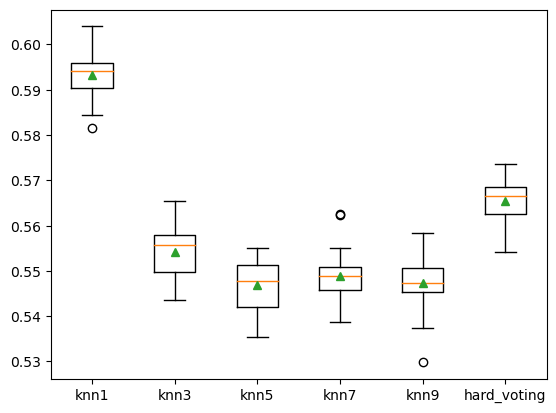

In [70]:
models = get_knn_models()

# evaluate the models and store results
results, names = process_models(models, x_train, y_train_clasificacion)

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [71]:
# define the base models
def set_knn_models(models):
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    return models[:]

In [72]:
# Si elegimos hard voting

# make a prediction with a hard voting ensemble

k_models = list()

knn_models = set_knn_models(k_models)

# define the hard voting ensemble
ensemble = VotingClassifier(estimators=knn_models, voting='hard')

# fit the model on all available data
ensemble.fit(x_train, y_train_clasificacion)

# make a prediction for one example
pred = ensemble.predict(x_test)
accuracy_score(y_test_clasificacion, pred)

0.42886910399696915

##### Soft Voting

In [ ]:
# define the base models
def set_svm_models(models):
    models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
    models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
    models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
    models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
    models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
    return models[:]

In [ ]:
# get a voting ensemble of models
def get_svm_voting():
    # define the base models
    models = list()
    models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
    models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
    models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
    models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
    models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

In [ ]:
# get a list of models to evaluate
def get_svm_models():
    models = dict()
    models['svm1'] = SVC(probability=True, kernel='poly', degree=1)
    models['svm2'] = SVC(probability=True, kernel='poly', degree=2)
    models['svm3'] = SVC(probability=True, kernel='poly', degree=3)
    models['svm4'] = SVC(probability=True, kernel='poly', degree=4)
    models['svm5'] = SVC(probability=True, kernel='poly', degree=5)
    models['soft_voting'] = get_svm_voting()
    return models

In [ ]:
# compare soft voting ensemble to standalone classifiers
# get the models to evaluate
svm_models = get_svm_models()

# evaluate the models and store results
results, names = process_models(svm_models, x_train, y_train_clasificacion)

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
ensemble = VotingClassifier(estimators=svm_models, voting='soft')

# fit the model on all available data
ensemble.fit(x_train, y_train_clasificacion)

# make a prediction for one example
pred = ensemble.predict(x_test)
accuracy_score(y_test_clasificacion, pred)

Despues de hacer los respectivos analisis, notamos que el approach de Vorting Soft resulto ser mas efectivo en accuracy que el Hard. **Soft = 0,82** VS **Hard = 0.79** de accuraccy. Nos quedaremos con el Soft.

### Ensamble Stacking

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    print(model_names)
    print(results)
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
        title='Performance of Different Models Using 5-Fold Cross-Validation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        xaxis_title='Model',
        yaxis_title='Accuracy',
        showlegend=False)
    fig.show()

Vamos a utilizar KNN, SV, Random Forest y Regresion Lineal.

Tambien vamos a definir un regresor de Stacking del modulo de Scikit Learn’s, seteando los estimadores base como los modelos base y como estimador finaluna regresion lineal con 5 cross folds.

In [ ]:
base_models = [
    ('KNN', KNeighborsRegressor()),
    ('SVR', SVR()),
    ('Random Forest', RandomForestRegressor()),
    ('Linear Regression', LinearRegression()),
], 'pileta', 'parrilla', 'balcon', 'sum'
stacked = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5)

Luego, vamos a fittear los modelos base y predecir la data de test que ya habiamos previamente separado en train (80%) y test (20%) para asi poder comparar los resultado con el ensamble regresor.

In [ ]:
import time
from collections import defaultdict

#Guarda los scores de cada modelo
model_scores = defaultdict()

for name, model in base_models:
    start_time = time.time()
    model.fit(x_train, y_train_clasificacion_factorized)
    prediction = model.predict(x_test), 'pileta', 'parrilla', 'balcon', 'sum'
    end_time = time.time()

    r2 = model.score(x_test, y_test_clasificacion_factorized)
    rmse = mean_squared_error(y_test_clasificacion_factorized, prediction, squared=False)
    model_scores[name] = r2

    print("-------{}-------".format(name))
    print("Coefficient of determination: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")

start_time = time.time()
stacked.fit(x_train, y_train_clasificacion_factorized)
stacked_prediction = stacked.predict(x_test)
end_time = time.time()
stacked_r2 = stacked.score(x_test, y_test_clasificacion_factorized)
model_scores['Stacking'] = stacked_r2
stacked_rmse = mean_squared_error(y_test_clasificacion_factorized, stacked_prediction, squared=False)
print("-------Stacked Ensemble-------")
print("Coefficient of determination: {}".format(stacked_r2))
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

El top 3 de los mejores modelos son:

    1. KNN
    2. Random Forest
    3. Ensamble de Stacking

Random Forest y el Ensamble estan a la par, mientras que KNN se separa por un muy pequeño porcentaje. El ensamble logra obtener grandes reusltados dada su naturaleza. El ensamble logra optimizar las mejores combincaiones lineales de los modelos permitiendonos obtener una mejor mezcla de diversidad de cada modelo y de cada predicción.
La unica contra que parece tener el ensamble es el tiempo computacional que tarda, es por ese motivo, y porque la metrica da levemente mejor, que en este caso, optamos por mencionar que KNN resulta superior.

In [ ]:
model_scores

In [ ]:
#Grafico performance, 'pileta', 'parrilla', 'balcon', 'sum'
plot_results(model_scores, name='stacking_model_cv')

## Conclusiones

In [ ]:
"""scaler = StandardScaler()
x_train_scaled = x_train.drop(axis=1, columns=['place_l3'])
x_train_scaled = scaler.fit_transform(pd.DataFrame(x_train_scaled))
x_test_scaled = x_test.drop(axis=1, columns=['place_l3'])
x_test_scaled = scaler.fit_transform(pd.DataFrame(x_test_scaled))
"""

In [ ]:
"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

# making predictions with the decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc_model = dtc.fit(x_train_scaled, y_train_clasificacion_factorized)
y_pred_dtc = dtc_model.predict(x_test_scaled)


# making predictions with the logistic regression model
lr = LogisticRegression()
lr_model = lr.fit(x_train_scaled, y_train_clasificacion_factorized)
y_pred_lr = lr_model.predict(x_test_scaled)


# making predictions with the naive bayes model
gnb = GaussianNB()
gnb_model = gnb.fit(x_train_scaled, y_train_clasificacion_factorized)
y_pred_gnb = gnb_model.predict(x_test_scaled)


# evaluating the models based on their f-1 scores
f1_dtc = f1_score(y_test_clasificacion_factorized, y_pred_dtc, average='micro')
f1_lr = f1_score(y_test_clasificacion_factorized, y_pred_lr, average='micro')
f1_gnb = f1_score(y_test_clasificacion_factorized, y_pred_gnb, average='micro')

# print the f-1 scores
print('F1-score of decision tree classifier: {}'.format(np.round(f1_dtc,4)))
print('F1-score of support vector machine: {}'.format(np.round(f1_lr,4)))
print('F1-score of naive bayes classifier: {}'.format(np.round(f1_gnb,4)))
"""

## Desition tree classifier

In [118]:
def mostrar_metricas(valores_reales, predicciones):
    #Results heatmap
    tabla = confusion_matrix(valores_reales, predicciones)
    sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g', ).set(title='Predicciones sobre el conjunto de entrenamiento')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Accuracy table
    metrics = classification_report(valores_reales, predicciones)
    print(metrics)

In [119]:
x_train_clas = x_train.drop(axis=1, columns=['place_l3'])
y_train_clas = y_train_clasificacion.replace(['Bajo', 'Medio', 'Alto'],[0,1,2])
x_test_clas = x_test.drop(axis=1, columns=['place_l3'])
y_test_clas = y_test_clasificacion.replace(['Bajo', 'Medio', 'Alto'],[0,1,2])

In [125]:
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

n = 10
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(11, 31)),
    'max_features': ["sqrt", "log2"],
    'min_samples_leaf': list(range(1, 9)),
    'ccp_alpha': np.linspace(0, 0.05, n)
}

folds = 5
kfoldcv = StratifiedKFold(n_splits=folds)
base_tree = DecisionTreeClassifier(random_state=4)
scorer_fn = make_scorer(sk.metrics.accuracy_score)
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=2)
randomcv.fit(x_train_clas, y_train_clas);
randomcv.best_params_

{'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 18,
 'criterion': 'entropy',
 'ccp_alpha': 0.0}

In [126]:
modelo_dct = randomcv.best_estimator_
predicciones_dct = modelo_dct.predict(x_test_clas)

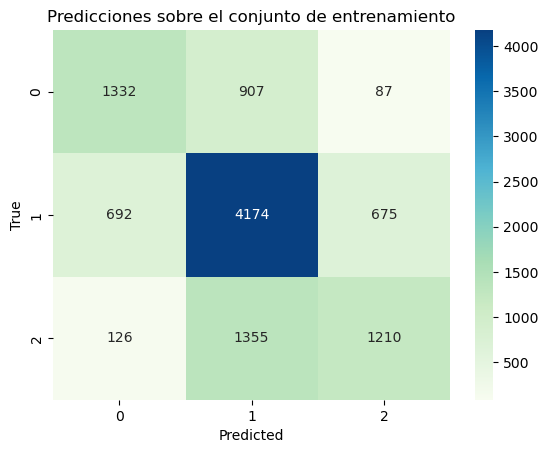

              precision    recall  f1-score   support

           0       0.62      0.57      0.60      2326
           1       0.65      0.75      0.70      5541
           2       0.61      0.45      0.52      2691

    accuracy                           0.64     10558
   macro avg       0.63      0.59      0.60     10558
weighted avg       0.63      0.64      0.63     10558



In [127]:
mostrar_metricas(y_test_clas, predicciones_dct)

In [128]:
predicciones_train = modelo_dct.predict(x_train_clas)

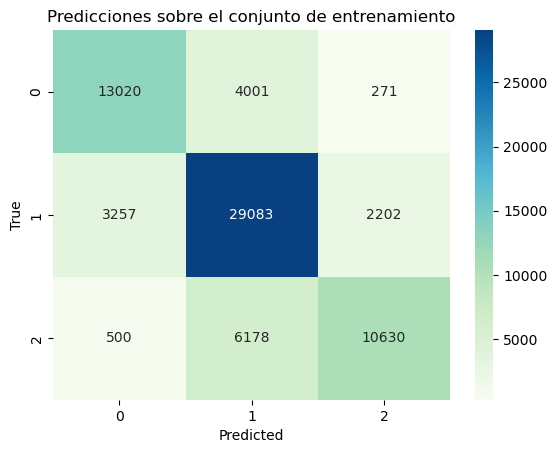

              precision    recall  f1-score   support

           0       0.78      0.75      0.76     17292
           1       0.74      0.84      0.79     34542
           2       0.81      0.61      0.70     17308

    accuracy                           0.76     69142
   macro avg       0.78      0.74      0.75     69142
weighted avg       0.77      0.76      0.76     69142



In [124]:
mostrar_metricas(y_train_clas, predicciones_train)

## Logistic Regression

## Naive bayes

## Random forest

In [ ]:
# import voting classifier
from sklearn.ensemble import VotingClassifier

# create a voting classifier with hard voting
voting_classifier_hard = VotingClassifier(
    estimators = [('dtc',dtc),
                  ('lr', lr),
                  ('gnb', gnb)], 
    voting='hard')

# create a voting classifier with soft voting
voting_classifier_soft = VotingClassifier(
    estimators = [('dtc',dtc),
                  ('lr', lr),
                  ('gnb', gnb)], 
    voting='soft')

# make predictions with the hard voting model
voting_classifier_hard.fit(x_train, y_train_clasificacion_factorized)
y_pred_vch = voting_classifier_hard.predict(x_test)

# make predictions with the soft voting model
voting_classifier_soft.fit(x_train, y_train_clasificacion_factorized)
y_pred_vcs = voting_classifier_soft.predict(x_test)

# evaluate both models with the f-1 score
f1_vch = f1_score(y_test_clasificacion_factorized, y_pred_vch, average='micro')
f1_vcs = f1_score(y_test_clasificacion_factorized, y_pred_vcs, average='micro')

# print the f-1 scores
print('F1-score of the hard voting classifier: {}'.format(np.round(f1_vch,4)))
print('F1-score of the soft voting classifier: {}'.format(np.round(f1_vcs,4)))